In [4]:
from bayesian_optimization.bo import BayesianOptimization
# from bayesian_optimization.acquisition_functions import AcquisitionFunction
from evaluation.decoder_based_evaluation import CSS_Evaluator
from bayesian_optimization.kernels import GNNKernel, WLSubtreeKernel,GNNEmbedding
from code_construction.code_construction import CodeConstructor
from bayesian_optimization.encoder import CSSEncoder
from bayesian_optimization.bo import LogicalErrorRatePerQubit
import torch
from bayesian_optimization.gp import GaussianProcess_QEC
import matplotlib.pyplot as plt
import torch.nn as nn
from grakel.kernels import WeisfeilerLehman, VertexHistogram,RandomWalkLabeled
from gpytorch.kernels import ScaleKernel, RBFKernel
import numpy as np
DEVICE='cuda'

# A Test
The first experiment is a test of runing Bayesian optimizations with these settings


- Construct the code using $\mathbb{Z}_m^{p\times q}$-LDPC-HypergraphProduct construction, where p=4,q=4,m=4.
- Kernel function is WL kernel.
- Acquisition function is EI, using random sampling.
- Evaluation function is Expected logical error rate per qubit using simple Monte-Carlo sampling. 


In [ ]:

class Get_new_points_function():
    def __init__(self,method='qc-ldpc-hgp',hyperparameters = {'p': 2, 'q': 6, 'm': 2},encode='None'):
        self.method = method
        self.hyperparameters = hyperparameters
        self.encode = encode

    def get_new_points_function(self,number):
        if self.method == 'qc-ldpc-hgp':
            new_points = self.get_new_points_HGP(number)
        elif self.method == 'canonical_css':
            new_points = self.get_new_points_cananical(number,css = True)
        elif self.method == 'canonical':
            new_points = self.get_new_points_cananical(number)
        
        return new_points
        
    def get_new_points_HGP(self,number):
        return np.random.randint(0, self.hyperparameters['m'] + 1, (number, self.hyperparameters['p'] * self.hyperparameters['q']))
    def get_new_points_cananical(self,number,css = False):
        n = self.hyperparameters['n']
        r = self.hyperparameters['r']
        k = self.hyperparameters['k']
        if css == False:
            return np.random.randint(0,2,(number,(n-r)*r+k*(n-k)+(1+r)*r//2))
        else:
            return np.random.randint(0,2,(number,(n-r)*r+(n-k-r)*k))
class OverallEncode():
    def __init__(self,code_constructor ,encoding_method = 'graph',grakel_use = False):
        self.code_constructor = code_constructor
        self.encoding_method = encoding_method
        self.grakel_use = grakel_use
        self.encoder = CSSEncoder(code_constructor.n,code_constructor.nx,code_constructor.nz,mode = encoding_method,grakel_use=self.grakel_use)
    def encode(self,x):
        
        if self.grakel_use == False:
            result = torch.cat([self.encoder.encode(self.code_constructor.construct(np.array(i).astype(int))).unsqueeze(0) for i in x],dim=0)
            result.to(DEVICE)
            # print(f'{result.size()}')
        else:
            # print(x.size())
            if x.dim()==2:
                result = [self.encoder.encode(self.code_constructor.construct(np.array(i).astype(int))) for i in x]
            elif x.dim()==3:
                result = [self.encode(i) for i in x]
        
        return result





# WLSubtreeKernel(72,36,36,num_iterations=3,encoder=OverallEncode(codeconstructor,'graph').encode)
results = []
p = 4
q = 4
m = 4
para_dict = {'p':p,'q':q,'m':m}
codeconstructor = CodeConstructor(method='qc-ldpc-hgp',para_dict = {'p':p,'q':q,'m':m})
gnp = Get_new_points_function(method='qc-ldpc-hgp',hyperparameters = para_dict).get_new_points_function
LERPQ = LogicalErrorRatePerQubit(codeconstructor,pp=0.001)
# print(LERPQ.forward(gnp(3)[0]))

# n = 31
# k= 1
# r = 15
# para_dict = {'n':n,'k':k,'r':r}
# codeconstructor = CodeConstructor(method='canonical_css',para_dict = para_dict)
# gnp = Get_new_points_function(method='canonical_css',hyperparameters = para_dict).get_new_points_function
# # print(codeconstructor.construct(gnp(1)[0]).hx)
# 
# LERPQ = LogicalErrorRatePerQubit(codeconstructor,pp=0.01)
# print(LERPQ.forward(gnp(1)[0]))
next_points_num = 4
candidate_num = 512
initial_sample_num = 15
bo_iteration = 100



In [ ]:
bo = BayesianOptimization(
                object_function=LERPQ.forward,
                get_new_points_function= gnp,
                bounds= torch.tensor([[0.0 for i in range(p*q)], [m for i in range(p*q)]]),
                normalizer_mode='log_pos_trans',
                kernel =ScaleKernel(RBFKernel()),
                encoder = None,
                acquisition_function=None,
                BO_iterations= bo_iteration,
                initial_sample_num = initial_sample_num,
                candidate_num = candidate_num,
                next_points_num = next_points_num,
                training_num = 5,
                description= 'Bayesian Optimization with RBF kernel and qc-ldpc-hgp construction'
            )

para,ler,evaluation_history = bo.run()

results.append({'para':para,'ler':ler,'evaluation_history':evaluation_history,'method':bo.description})
plt.plot(evaluation_history)
plt.yscale('log')  
plt.xlabel('Iterations')
plt.ylabel('Evaluation History')
plt.title('Evaluation History (Log Scale)')
plt.show()

print(ler)
print(para)

In [ ]:
random_points = gnp(bo_iteration*next_points_num+initial_sample_num)
LERPQ = LogicalErrorRatePerQubit(codeconstructor)


ler_random = [LERPQ.forward(x) for x in random_points] # print code rate
print(random_points[np.argmin(ler_random)])
print(min(ler_random))
results.append({'para':random_points[np.argmin(ler_random)],'ler':min(ler_random),'evaluation_history':[],'method':'random search'})


[2 0 0 3 0 0 0 2 1]
0.0006943432361714574


# Weisfeiler-Lehman kernel or Random Walk Kernel

/home/cyyh/miniconda3/envs/QEC2/lib/python3.10/site-packages/ldpc/_legacy_ldpc_v1/_legacy_bposd_decoder.py:45: UserWarning: This is the old syntax for the `bposd_decoder` from `ldpc v1`. Use the `BpOsdDecoder` class from `ldpc v2` for additional features.
  warnings.warn(


Initializing the object function values of the initial points...tensor([0.0033, 0.0137, 0.0216, 0.0108, 0.0145, 0.0026, 0.0140, 0.0258, 0.0086,
        0.0226, 0.0055, 0.0221, 0.0159, 0.0108, 0.0080], dtype=torch.float64)
The performance of the initial points:<class 'torch.Tensor'>,torch.Size([15, 9]),<class 'torch.Tensor'>,torch.Size([15]),tensor([ 1.7487, -0.3086, -0.9689,  0.0430, -0.3825,  2.0862, -0.3365, -1.2316,
         0.3697, -1.0355,  1.0307, -1.0068, -0.5172,  0.0362,  0.4732])
fitting the GP model...
Initial best value: 2.0862


Bayesian Optimization with RW kernel and qc-ldpc-hgp construction (Best value: 0.00018923734920268262)(GP MLL: 24.86447525024414),time:suggesting next:43.81564140319824,evaluate: 3.5167973041534424,training: 9.954475164413452: 100%|██████████| 50/50 [35:45<00:00, 42.90s/it]   


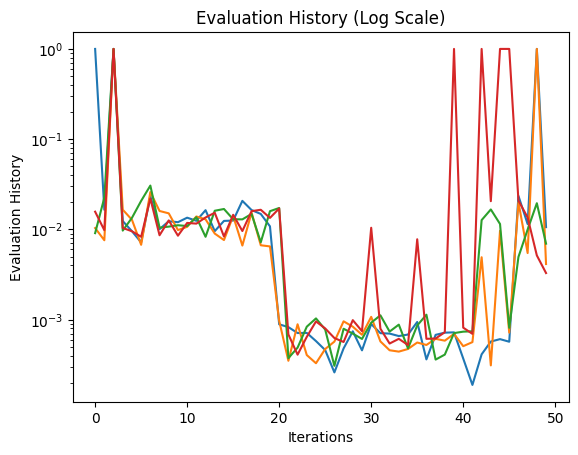

tensor(0.0002, dtype=torch.float64)
[2 3 0 0 0 1 0 0 3]


In [13]:
kernel = WeisfeilerLehman(n_iter=4, normalize=True, base_graph_kernel=VertexHistogram)
def make_positive_semidefinite(kernel_matrix, epsilon=1e-3):
    regularized_kernel = kernel_matrix + epsilon * torch.eye(kernel_matrix.size(0))
    eigenvalues, eigenvectors = torch.linalg.eigh(regularized_kernel)
    eigenvalues_clipped = torch.clamp(eigenvalues, min=0)
    kernel_matrix_psd = eigenvectors @ torch.diag(eigenvalues_clipped) @ eigenvectors.T
    return kernel_matrix_psd.float()
def WLkernel_function(x):
    return make_positive_semidefinite(torch.tensor(kernel.fit_transform(x)))
rwkernel = RandomWalkLabeled(normalize=True)
def RWkernel_function(x):
    return make_positive_semidefinite(torch.tensor(rwkernel.fit_transform(x)))

gnp = Get_new_points_function(hyperparameters = {'p': p, 'q': p, 'm': m},encode='None').get_new_points_function
encoder = OverallEncode(codeconstructor,encoding_method='graph',grakel_use=True)

bo = BayesianOptimization(
                object_function=LogicalErrorRatePerQubit(codeconstructor).forward,
                get_new_points_function= gnp,
                bounds= torch.tensor([[0.0 for i in range(p*q)], [m for i in range(p*q)]]),
                normalizer_mode='log_pos_trans',
                kernel =WLkernel_function,
                encoder = encoder.encode,
                acquisition_function=None,
                BO_iterations= bo_iteration,
                initial_sample_num = initial_sample_num,
                candidate_num = candidate_num,
                next_points_num = next_points_num,
                training_num = 1,
                description= 'Bayesian Optimization with RW kernel and qc-ldpc-hgp construction'
            )


para,ler,evaluation_history = bo.run()
results.append({'para':para,'ler':ler,'evaluation_history':evaluation_history,'method':bo.description})
plt.plot(evaluation_history)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Evaluation History')
plt.title('Evaluation History (Log Scale)')
plt.show()

print(ler)
print(para)

# GNN kernel

Initializing the object function values of the initial points...tensor([0.0012, 0.0046, 0.0019, 0.0050, 0.0043, 0.0017, 0.0008, 0.0028, 0.0074,
        0.0015, 0.0010, 0.0018, 0.0020, 0.0035, 0.0066], dtype=torch.float64)
The performance of the initial points:<class 'torch.Tensor'>,torch.Size([15, 16]),<class 'torch.Tensor'>,torch.Size([15]),tensor([ 1.0497, -0.9090,  0.4064, -1.0149, -0.8013,  0.5642,  1.5902, -0.1773,
        -1.5957,  0.7311,  1.3160,  0.4392,  0.3127, -0.4941, -1.4173])
fitting the GP model...
Initial best value: 1.5902


Bayesian Optimization with Graph Neural Network kernel(with out pre-training) and qc-ldpc-hgp construction (Best value: 6.690249758938782e-05)(GP MLL: 12.421074867248535),time:suggesting next:137.92555165290833,evaluate: 13.504520893096924,training: 317.5903482437134: 100%|██████████| 50/50 [4:07:26<00:00, 296.94s/it]   


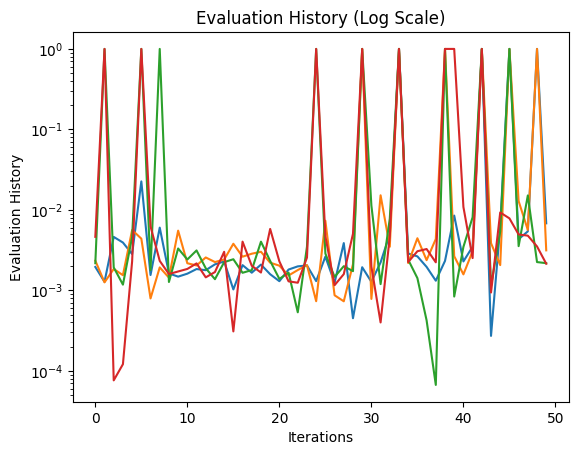

tensor(6.6902e-05, dtype=torch.float64)
[0 3 0 0 0 0 4 4 1 4 0 0 3 4 3 2]


In [6]:

gnp = Get_new_points_function(hyperparameters = {'p': p, 'q': p, 'm': m},encode='None').get_new_points_function
codeconstructor = CodeConstructor(method='qc-ldpc-hgp',para_dict = {'p':p,'q':q,'m':m})
encoder = OverallEncode(codeconstructor,encoding_method='graph',grakel_use=False)
gnnkernel_function = ScaleKernel(RBFKernel())
embedding = GNNEmbedding(m**2*(p**2+q**2),m**2*p*q,m**2*p*q)
bo = BayesianOptimization(
                object_function=LERPQ.forward,
                get_new_points_function= gnp,
                bounds= torch.tensor([[0.0 for i in range(p*q)], [m for i in range(p*q)]]),
                normalizer_mode='log_pos_trans',
                kernel =gnnkernel_function,
                encoder = encoder.encode,
                embedding=embedding,
                acquisition_function=None,
                BO_iterations= bo_iteration,
                initial_sample_num = initial_sample_num,
                candidate_num = candidate_num,
                next_points_num = next_points_num,
                training_num = 10,
                description= 'Bayesian Optimization with Graph Neural Network kernel(with out pre-training) and qc-ldpc-hgp construction'
            )
para,ler,evaluation_history = bo.run()

plt.plot(evaluation_history)
plt.yscale('log')  
plt.xlabel('Iterations')
plt.ylabel('Evaluation History')
plt.title('Evaluation History (Log Scale)')
plt.show()

print(ler)
print(para)
results.append({'para':para,'ler':ler,'evaluation_history':evaluation_history,'method':bo.description})

[0 1 2 0 1 0 0 0 0]


In [ ]:
# import json
# results_serializable = json.loads(json.dumps(results, default=lambda x: x.tolist()))
# with open('result.json','w') as f:
#     json.dump(results_serializable, f, indent=4)